# Setup

In [ ]:
!git clone https://github.com/kddubey/pretrain-on-test.git

In [2]:
%cd pretrain-on-test/

/content/pretrain-on-test


In [ ]:
!pip install --upgrade pymc

In [ ]:
!pip install numpyro[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
!python -m pip install .[meta]

In [6]:
import os

import arviz as az
import bambi as bmb
from IPython.display import display
import pandas as pd
import seaborn as sns
import torch

In [7]:
sns.set_theme(style="darkgrid")

In [ ]:
num_test = 200

# Load data

In [8]:
models = ["bert", "gpt2"]
_accuracy_dfs = []

for model in models:
    accuracies_dir = os.path.join("accuracies_from_paper", num_test, model)
    _dfs = []
    for dataset in sorted(os.listdir(accuracies_dir)):
        _df = pd.read_csv(os.path.join(accuracies_dir, dataset, "accuracies.csv"))
        _df["dataset"] = dataset
        _dfs.append(_df)
    _accuracy_df = pd.concat(_dfs)
    _accuracy_df["model"] = model
    _accuracy_df = _accuracy_df[["model", "dataset", "base", "extra", "test"]]
    _accuracy_dfs.append(_accuracy_df)
accuracy_df = pd.concat(_accuracy_dfs)

In [9]:
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(
    int, errors="raise"
)
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df["model"] = accuracy_df["model"].copy()
num_correct_df = num_correct_df[["model", "dataset", "base", "extra", "test"]]
num_correct_df["pair"] = range(len(num_correct_df))
num_correct_df

,model,dataset,base,extra,test,pair
0,bert,ag_news,167,176,167,0
1,bert,ag_news,120,169,162,1
2,bert,ag_news,125,163,168,2
3,bert,ag_news,128,159,172,3
4,bert,ag_news,117,167,164,4
...,...,...,...,...,...,...
45,gpt2,yelp_review_full,49,52,63,1995
46,gpt2,yelp_review_full,61,68,68,1996
47,gpt2,yelp_review_full,59,68,68,1997
48,gpt2,yelp_review_full,44,39,52,1998


In [10]:
def stat_model(
    num_correct_df: pd.DataFrame, control_column: str, treatment_column: str
) -> tuple[bmb.Model, az.InferenceData]:
    df = (
        num_correct_df[["pair", "model", "dataset", control_column, treatment_column]]
        .melt(["pair", "model", "dataset"], var_name="method", value_name="num_correct")
        .sort_values("pair")
        .reset_index(drop=True)
    )
    # Pairs/subsamples were formed from the dataset. So it's nested, not crossed.
    # Technically, crossed notation—(1|dataset) + (1|pair)—would still result in a
    # nested inference b/c pair is uniquely coded
    model = bmb.Model(
        "num_correct ~ method + (1|model) + (1|dataset/pair)", family="poisson", data=df
    )
    inference_method = "mcmc" if not torch.cuda.is_available() else "nuts_numpyro"
    fit_summary: az.InferenceData = model.fit(
        inference_method=inference_method, chains=1, random_seed=123, cores=1
    )
    az_summary: pd.DataFrame = az.summary(fit_summary)
    display(
        az_summary.loc[
            [index_name for index_name in az_summary.index if "method" in index_name]
        ]
    )

    az.plot_trace(fit_summary, compact=False, var_names="method", filter_vars="like")
    return model, fit_summary

sample: 100%|██████████| 2000/2000 [18:50<00:00,  1.77it/s, 1023 steps of size 1.98e-03. acc. prob=0.90]
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.136,0.003,0.13,0.142,0.0,0.0,574.0,787.0,NaN


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


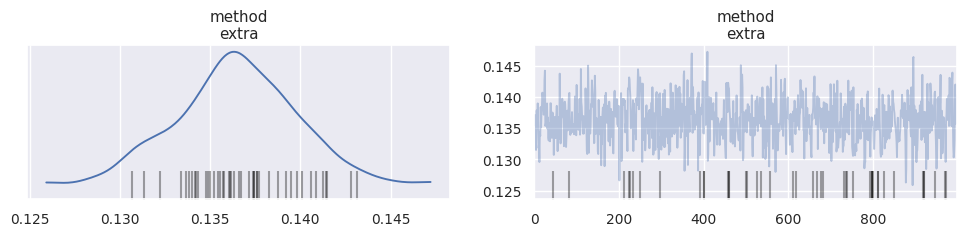

In [11]:
model_control, summary_control = stat_model(
    num_correct_df, control_column="base", treatment_column="extra"
)

In [12]:
print(model_control)

       Formula: num_correct ~ method + (1|model) + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 4000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|model ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


/usr/local/lib/python3.10/dist-packages/pytensor/link/vm.py:1164: UserWarning: Detected reference count inconsistency after CVM construction
  warnings.warn(
sample: 100%|██████████| 2000/2000 [18:14<00:00,  1.83it/s, 1023 steps of size 2.30e-03. acc. prob=0.88]
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],0.005,0.003,-0.001,0.011,0.0,0.0,734.0,758.0,NaN


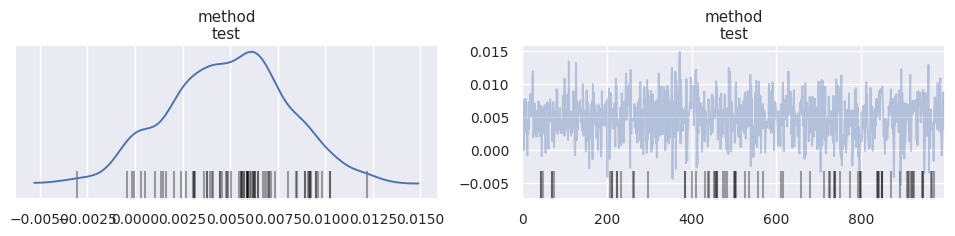

In [13]:
model_bias, summary_bias = stat_model(
    num_correct_df, control_column="extra", treatment_column="test"
)

In [14]:
print(model_bias)

       Formula: num_correct ~ method + (1|model) + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 4000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|model ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
